In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from transformers import BertTokenizer, BertModel
import torch
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv('../BindDBdata/TTD/final_drug_target_ttd.csv')
data.head()

,TargetID,DrugID,Highest_status,MOA,TARGNAME,sequence,smiles,Pubchem CID,Activity
0,T38529,D00SOZ,Approved,Agonist,Prostaglandin E2 receptor EP2 (PTGER2),MGNASNDSQSEDCETRQWLPPGESPAISSVMFSAGVLGNLIALALL...,CC(C)OC(=O)CNc1cccc(CN(Cc2ccc(-n3cccn3)cc2)S(=...,44230999.0,IC50 = 4180 nM
1,T73189,D02URM,Approved,Inhibitor,"Fungal 1,3-beta-glucan synthase (Fung GSC2)",MSYNDPNLNGQYYSNGDGTGDGNYPTYQVTQDQSAYDEYGQPIYTQ...,CCCCCOc1ccc(-c2ccc(-c3ccc(C(=O)N[C@H]4C[C@@H](...,NaN,NaN
2,T73189,D07INL,Approved,Inhibitor,"Fungal 1,3-beta-glucan synthase (Fung GSC2)",MSYNDPNLNGQYYSNGDGTGDGNYPTYQVTQDQSAYDEYGQPIYTQ...,CC(C)[C@@H](C)[C@@]1(C)CC[C@]2(C)[C@H]3CC[C@@H...,NaN,NaN
3,T89534,D07KUN,Approved,Modulator,Estrogen receptor (ESR),MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,CCNCCc1ccc(CN(CC)c2cc(OC)ccc2[C@@H]2CCc3cc(O)c...,NaN,NaN
4,T21678,D07URD,Approved,Modulator,Alpha-galactosidase A (GLA),MQLRNPELHLGCALALRFLALVSWDIPGARALDNGLARTPTMGWLH...,N[C@@H](CCCCNC(=O)CCC(=O)NCCOCCNC(=O)CCC(=O)NC...,NaN,NaN


In [5]:
# Function to generate negative pairs
def generate_negative_pairs(df, negative_positive_ratio=1):
    # Extract unique drugs and targets
    unique_drugs = df['DrugID'].unique()
    unique_targets = df['TargetID'].unique()
    
    # Create a set of positive pairs for quick lookup
    positive_pairs = set(zip(df['DrugID'], df['TargetID']))
    
    # Calculate the number of negative pairs needed
    num_positive_pairs = len(df)
    num_negative_pairs = int(num_positive_pairs * negative_positive_ratio)
    
    # Generate negative pairs
    negative_pairs = set()
    while len(negative_pairs) < num_negative_pairs:
        drug = random.choice(unique_drugs)
        target = random.choice(unique_targets)
        if (drug, target) not in positive_pairs and (drug, target) not in negative_pairs:
            negative_pairs.add((drug, target))
    
    # Create a DataFrame for negative pairs
    negative_df = pd.DataFrame(list(negative_pairs), columns=['DrugID', 'TargetID'])
    return negative_df

In [7]:
# Generate negative pairs with a 1:1 ratio
negative_df = generate_negative_pairs(data, negative_positive_ratio=1)

# Merge negative pairs with original dataframe to retain required columns
negative_df = negative_df.merge(data[['DrugID', 'smiles']].drop_duplicates(),
                                on='DrugID', how='left')
negative_df = negative_df.merge(data[['TargetID', 'sequence']].drop_duplicates(),
                                on='TargetID', how='left')

# Rearrange columns for clarity
negative_df = negative_df[['DrugID', 'smiles', 
                           'TargetID', 'sequence']]
positive_df = data[['DrugID', 'smiles',
                    'TargetID', 'sequence']]


In [8]:
# Add labels to positive (1) and negative (0) dataframes
positive_df['label'] = 1
negative_df['label'] = 0

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_90956/2616654014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df['label'] = 1


In [ ]:
# Combine positive and negative datasets
combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

In [12]:
combined_df['label'].value_counts()

label
1    29590
0    29590
Name: count, dtype: int64

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load ChemRoBERTa tokenizer and model
chem_tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
chem_model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Load ESM2 tokenizer and model
esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_model = AutoModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import AutoTokenizer, AutoModel

# esm_tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t33_650M_UR50D")
# esm_model = AutoModel.from_pretrained("facebook/esm2_t33_650M_UR50D")
# print(esm_model.config.hidden_size)  # Should output 768


In [15]:
def extract_chem_features(smiles):
    """Extract ChemRoBERTa features from SMILES."""
    try:
        tokens = chem_tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = chem_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(768)  # Return zero vector if extraction fails

def extract_esm_features(sequence):
    """Extract ESM2 features from protein sequence."""
    try:
        tokens = esm_tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            embeddings = esm_model(**tokens).last_hidden_state.mean(dim=1).squeeze().numpy()
        return embeddings
    except:
        return np.zeros(320)  # Return zero vector if extraction fails

In [16]:
print(esm_model.config.hidden_size)  # Should output 768


320


In [49]:
# Function to featurize drug SMILES into molecular fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    else:
        return np.zeros(2048)

# Load ProtBERT for protein embedding
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert")
model = BertModel.from_pretrained("Rostlab/prot_bert")

# Function to featurize protein sequences
def featurize_protein(sequence):
    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

python(37279) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
# Featurize drugs
# Extract unique drugs and proteins
unique_drugs = combined_df[['smiles']].drop_duplicates()
unique_proteins = combined_df[['sequence']].drop_duplicates()


In [18]:
len(unique_drugs)

19746

In [19]:
len(unique_proteins)

1870

In [20]:
# Extract features for unique drugs
tqdm.pandas()  # Enable progress bar for pandas
unique_drugs['drug_features'] = unique_drugs['smiles'].progress_apply(extract_chem_features)

  0%|          | 0/19746 [00:00<?, ?it/s]

100%|██████████| 19746/19746 [10:59<00:00, 29.95it/s] 


In [21]:
# Extract features for unique proteins
unique_proteins['protein_features'] = unique_proteins['sequence'].progress_apply(extract_esm_features)

100%|██████████| 1870/1870 [11:06<00:00,  2.81it/s]  


In [22]:
# Merge features back into the combined dataframe
combined_df = combined_df.merge(unique_drugs, on='smiles', how='left')
combined_df = combined_df.merge(unique_proteins, on='sequence', how='left')

In [29]:
torch.save(combined_df, '../BindDBdata/TTD/final_drug_target_ttd_combined.pt')

In [2]:
combined_df = torch.load('../BindDBdata/TTD/final_drug_target_ttd_combined.pt')

/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_40242/6185232.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  combined_df = torch.load('../BindDBdata/TTD/fina

In [3]:
# DataFrame to store AUCs

auc_history = pd.DataFrame(columns=['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC'])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define dataset
class DTI_Dataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        return {
            'drug_features': torch.tensor(np.asarray(row['drug_features'], dtype=np.float32)),
            'protein_features': torch.tensor(np.asarray(row['protein_features'], dtype=np.float32)),
            'label': torch.tensor(float(row['label']), dtype=torch.float32),
        }

# Define Diffusion Generative Model
class DiffusionGenerativeModel(nn.Module):
    def __init__(self, drug_input_dim, protein_input_dim, hidden_dim, num_timesteps):
        super(DiffusionGenerativeModel, self).__init__()
        self.num_timesteps = num_timesteps
        self.drug_encoder = nn.Linear(drug_input_dim, hidden_dim)
        self.protein_encoder = nn.Linear(protein_input_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.dropout = nn.Dropout(0.3)
        self.denoise_model = nn.Linear(hidden_dim * 2, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, drug_features, protein_features, t):
        # Encode drug and protein features
        drug_embedding = self.activation(self.drug_encoder(drug_features))
        protein_embedding = self.activation(self.protein_encoder(protein_features))

        # Concatenate embeddings
        combined = torch.cat((drug_embedding, protein_embedding), dim=-1)
        combined = self.layer_norm(combined)
        combined = self.dropout(combined)

        # Add learnable timestep embedding
        t_embedding = nn.Embedding(self.num_timesteps, combined.size(1))(t.long())
        combined += t_embedding

        # Denoise process
        denoised = self.activation(self.denoise_model(combined))

        # Classification layer
        output = torch.sigmoid(self.classifier(denoised))
        return output

    def add_noise(self, x, noise_level=0.1):
        noise = noise_level * torch.randn_like(x)
        return x + noise

# Load data
# Assuming `combined_df` is a pandas DataFrame containing all necessary columns
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_dataset = DTI_Dataset(train_df)
val_dataset = DTI_Dataset(val_df)
test_dataset = DTI_Dataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [5]:
# Verify feature dimensions
for batch in train_loader:
    drug_input_dim = batch['drug_features'].shape[1]  # Dynamically determine drug input dimension
    protein_input_dim = batch['protein_features'].shape[1]  # Dynamically determine protein input dimension
    break

# Initialize model, optimizer, and loss function
num_timesteps = 10
model = DiffusionGenerativeModel(drug_input_dim=drug_input_dim, protein_input_dim=protein_input_dim, hidden_dim=512, num_timesteps=num_timesteps)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
pos_weight = torch.tensor([len(train_df) / train_df['label'].sum() - 1], dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Training and Validation Loop
for epoch in range(200):
    model.train()
    total_loss = 0
    val_total_loss = 0
    train_predictions, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        optimizer.zero_grad()
        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Store predictions and labels for AUC calculation
        train_predictions.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Calculate AUC for training
    train_auc = roc_auc_score(train_labels, train_predictions)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Train Loss: {total_loss / len(train_loader):.4f}, Train AUC: {train_auc:.4f}")

    # Validation AUC
    model.eval()
    val_predictions, val_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            drug_features = batch['drug_features']
            protein_features = batch['protein_features']
            labels = batch['label']

            # Add noise to the features
            noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
            noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

            outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
            val_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

    val_auc = roc_auc_score(val_labels, val_predictions)
    if epoch % 10 == 0:
        print(f"Epoch {epoch + 1} - Validation Loss: {val_total_loss / len(val_loader):.4f}, Validation AUC: {val_auc:.4f}")
    
     # Save AUC to DataFrame
    new_row = {'epoch': epoch + 1, 'Train Loss': total_loss / len(train_loader), 'Train AUC': train_auc, 'Val Loss': val_total_loss / len(val_loader), 'Val AUC': val_auc}
    auc_history = pd.concat([auc_history, pd.DataFrame([new_row])], ignore_index=True)

# Test AUC
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        test_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_auc = roc_auc_score(test_labels, test_predictions)
print(f"Test AUC: {test_auc:.4f}")


Training Epoch 1: 100%|██████████| 1295/1295 [00:23<00:00, 55.77it/s]


Epoch 1 - Train Loss: 0.6674, Train AUC: 0.6316


/var/folders/7_/j8_cym2s23jfxbknz2gsv_h80000gn/T/ipykernel_40242/4070280312.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  auc_history = pd.concat([auc_history, pd.DataFrame([new_row])], ignore_index=True)


Epoch 1 - Validation Loss: 0.6594, Validation AUC: 0.6585


Training Epoch 11: 100%|██████████| 1295/1295 [00:15<00:00, 82.61it/s]


Epoch 11 - Train Loss: 0.6293, Train AUC: 0.7305
Epoch 11 - Validation Loss: 0.6280, Validation AUC: 0.7310


Training Epoch 21: 100%|██████████| 1295/1295 [00:18<00:00, 68.95it/s]


Epoch 21 - Train Loss: 0.6210, Train AUC: 0.7466
Epoch 21 - Validation Loss: 0.6206, Validation AUC: 0.7508


Training Epoch 31: 100%|██████████| 1295/1295 [00:20<00:00, 64.21it/s]


Epoch 31 - Train Loss: 0.6160, Train AUC: 0.7556
Epoch 31 - Validation Loss: 0.6191, Validation AUC: 0.7541


Training Epoch 41: 100%|██████████| 1295/1295 [00:16<00:00, 79.02it/s]


Epoch 41 - Train Loss: 0.6121, Train AUC: 0.7642
Epoch 41 - Validation Loss: 0.6157, Validation AUC: 0.7616


Training Epoch 51: 100%|██████████| 1295/1295 [00:20<00:00, 64.30it/s]


Epoch 51 - Train Loss: 0.6089, Train AUC: 0.7718
Epoch 51 - Validation Loss: 0.6138, Validation AUC: 0.7659


Training Epoch 61: 100%|██████████| 1295/1295 [00:16<00:00, 80.31it/s]


Epoch 61 - Train Loss: 0.6062, Train AUC: 0.7807
Epoch 61 - Validation Loss: 0.6115, Validation AUC: 0.7750


Training Epoch 71: 100%|██████████| 1295/1295 [00:23<00:00, 55.28it/s]


Epoch 71 - Train Loss: 0.6033, Train AUC: 0.7904
Epoch 71 - Validation Loss: 0.6104, Validation AUC: 0.7782


Training Epoch 81: 100%|██████████| 1295/1295 [00:19<00:00, 64.82it/s]


Epoch 81 - Train Loss: 0.5980, Train AUC: 0.8083
Epoch 81 - Validation Loss: 0.6042, Validation AUC: 0.7995


Training Epoch 91: 100%|██████████| 1295/1295 [01:06<00:00, 19.35it/s]


Epoch 91 - Train Loss: 0.5949, Train AUC: 0.8168
Epoch 91 - Validation Loss: 0.6041, Validation AUC: 0.8036


Training Epoch 101: 100%|██████████| 1295/1295 [00:18<00:00, 70.52it/s]


Epoch 101 - Train Loss: 0.5915, Train AUC: 0.8237
Epoch 101 - Validation Loss: 0.6048, Validation AUC: 0.8074


Training Epoch 111: 100%|██████████| 1295/1295 [00:14<00:00, 88.95it/s]


Epoch 111 - Train Loss: 0.5893, Train AUC: 0.8285
Epoch 111 - Validation Loss: 0.6023, Validation AUC: 0.8128


Training Epoch 121: 100%|██████████| 1295/1295 [00:15<00:00, 86.11it/s]


Epoch 121 - Train Loss: 0.5872, Train AUC: 0.8333
Epoch 121 - Validation Loss: 0.6017, Validation AUC: 0.8169


Training Epoch 131: 100%|██████████| 1295/1295 [00:17<00:00, 75.62it/s]


Epoch 131 - Train Loss: 0.5853, Train AUC: 0.8369
Epoch 131 - Validation Loss: 0.5994, Validation AUC: 0.8161


Training Epoch 141: 100%|██████████| 1295/1295 [00:14<00:00, 88.14it/s]


Epoch 141 - Train Loss: 0.5832, Train AUC: 0.8396
Epoch 141 - Validation Loss: 0.5968, Validation AUC: 0.8204


Training Epoch 151: 100%|██████████| 1295/1295 [00:19<00:00, 68.07it/s]


Epoch 151 - Train Loss: 0.5813, Train AUC: 0.8442
Epoch 151 - Validation Loss: 0.5989, Validation AUC: 0.8219


Training Epoch 161: 100%|██████████| 1295/1295 [00:20<00:00, 64.42it/s]


Epoch 161 - Train Loss: 0.5775, Train AUC: 0.8770
Epoch 161 - Validation Loss: 0.5918, Validation AUC: 0.8507


Training Epoch 171: 100%|██████████| 1295/1295 [00:23<00:00, 54.08it/s]


Epoch 171 - Train Loss: 0.5729, Train AUC: 0.8886
Epoch 171 - Validation Loss: 0.5893, Validation AUC: 0.8595


Training Epoch 181: 100%|██████████| 1295/1295 [00:29<00:00, 43.17it/s]


Epoch 181 - Train Loss: 0.5708, Train AUC: 0.8942
Epoch 181 - Validation Loss: 0.5880, Validation AUC: 0.8644


Training Epoch 191: 100%|██████████| 1295/1295 [00:29<00:00, 43.73it/s]


Epoch 191 - Train Loss: 0.5679, Train AUC: 0.8972
Epoch 191 - Validation Loss: 0.5865, Validation AUC: 0.8688


Training Epoch 200: 100%|██████████| 1295/1295 [00:22<00:00, 57.25it/s]


Test AUC: 0.8719


In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Test Evaluation with Additional Metrics
model.eval()
test_predictions, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        drug_features = batch['drug_features']
        protein_features = batch['protein_features']
        labels = batch['label']

        # Add noise to the features
        noisy_drug_features = model.add_noise(drug_features, noise_level=0.1)
        noisy_protein_features = model.add_noise(protein_features, noise_level=0.1)

        outputs = model(noisy_drug_features, noisy_protein_features, torch.randint(0, num_timesteps, (drug_features.size(0),))).squeeze()
        test_predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Convert predictions to binary
test_predictions_binary = (np.array(test_predictions) >= 0.65).astype(int)

# Calculate Metrics
test_auc = roc_auc_score(test_labels, test_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions_binary)
test_precision = precision_score(test_labels, test_predictions_binary, zero_division=0)
test_recall = recall_score(test_labels, test_predictions_binary, zero_division=0)
test_f1 = f1_score(test_labels, test_predictions_binary, zero_division=0)

# Sensitivity and Specificity
tn, fp, fn, tp = confusion_matrix(test_labels, test_predictions_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

# Print Results
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall (Sensitivity): {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Specificity: {test_specificity:.4f}")

Test AUC: 0.8735
Test Accuracy: 0.8192
Test Precision: 0.8803
Test Recall (Sensitivity): 0.7388
Test F1-Score: 0.8034
Test Specificity: 0.8995


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Initialize DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Model', 'Dataset', 'AUC', 'Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'Recall', 'F1-Score'])

def calculate_metrics(y_true, y_pred_proba, y_pred):
    """
    Calculate performance metrics.
    """
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    return auc, accuracy, sensitivity, specificity, precision, recall, f1

def evaluate_model(model_name, model, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate a model, and save metrics to DataFrame.
    """
    global metrics_df

    # Train predictions
    train_pred_proba = model.predict_proba(X_train)[:, 1]
    train_pred = (train_pred_proba >= 0.5).astype(int)
    train_metrics = calculate_metrics(y_train, train_pred_proba, train_pred)
    
    # Validation predictions
    val_pred_proba = model.predict_proba(X_val)[:, 1]
    val_pred = (val_pred_proba >= 0.5).astype(int)
    val_metrics = calculate_metrics(y_val, val_pred_proba, val_pred)

    # Test predictions
    test_pred_proba = model.predict_proba(X_test)[:, 1]
    test_pred = (test_pred_proba >= 0.5).astype(int)
    test_metrics = calculate_metrics(y_test, test_pred_proba, test_pred)

    # Append metrics to DataFrame
    datasets = ['Training', 'Validation', 'Test']
    metrics = [train_metrics, val_metrics, test_metrics]
    rows = []
    for dataset, metric in zip(datasets, metrics):
        auc, accuracy, sensitivity, specificity, precision, recall, f1 = metric
        rows.append({
            'Model': model_name,
            'Dataset': dataset,
            'AUC': auc,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })
    
    # Update metrics_df
    metrics_df = pd.concat([metrics_df, pd.DataFrame(rows)], ignore_index=True)

# Load your data
# Assuming `combined_df` contains all necessary columns
# Split into train, validation, and test sets
train_df, temp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

X_train = np.hstack((np.vstack(train_df['drug_features']), np.vstack(train_df['protein_features'])))
X_val = np.hstack((np.vstack(val_df['drug_features']), np.vstack(val_df['protein_features'])))
X_test = np.hstack((np.vstack(test_df['drug_features']), np.vstack(test_df['protein_features'])))
y_train, y_val, y_test = train_df['label'], val_df['label'], test_df['label']

# Scale features for certain models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print('Random Forest')
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
evaluate_model('Random Forest', rf_model, X_train, y_train, X_val, y_val, X_test, y_test)
print('SVM')
# SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
evaluate_model('SVM', svm_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
print('GBM')
# GBM
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_model.fit(X_train, y_train)
evaluate_model('GBM', gbm_model, X_train, y_train, X_val, y_val, X_test, y_test)
print('Logistic Regression')
# Logistic Regression
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train_scaled, y_train)
evaluate_model('Logistic Regression', log_reg_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)
print('MLP')
# MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', max_iter=200, random_state=42)
mlp_model.fit(X_train_scaled, y_train)
evaluate_model('MLP', mlp_model, X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

# # Save metrics_df to CSV
# metrics_df.to_csv("model_comparison_metrics.csv", index=False)

In [25]:
auc_history.tail()

,epoch,Train Loss,Train AUC,Val Loss,Val AUC
995,996,0.532451,0.963410,0.575953,0.894960
996,997,0.531409,0.964915,0.576616,0.895653
997,998,0.531204,0.964244,0.576329,0.894895
998,999,0.532672,0.963647,0.574827,0.894920
999,1000,0.532089,0.963088,0.577133,0.894215


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

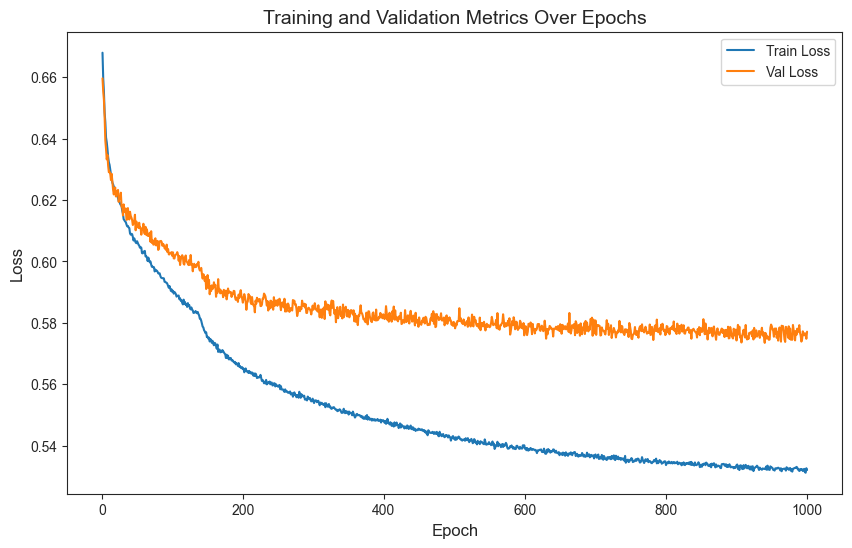

In [28]:
# Load metrics

metrics = auc_history
metrics[['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC']] = metrics[['epoch', 'Train Loss', 'Train AUC', 'Val Loss', 'Val AUC']].astype(float)

# Plot the training loss over epochs using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=metrics, x='epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=metrics, x='epoch', y='Val Loss', label='Val Loss')
# sns.lineplot(data=metrics, x='epoch', y='Train AUC', label='Train AUC')
# sns.lineplot(data=metrics, x='epoch', y='Val AUC', label='Val AUC')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_RMSE', label='Valid_RMSE')
# sns.lineplot(data=metrics, x='Epoch', y='Valid_MAE', label='Valid_MAE')
# Add titles and labels
plt.title('Training and Validation Metrics Over Epochs', fontsize=14)
# Define the range of tick positions
# plt.xticks(ticks=np.arange(0, epochs+1, 500))  # Adjust step size as needed
# plt.xlim(-50, epochs+50)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(False)
# Show the plot
plt.show()